In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 19.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ultralytics
ultralytics.checks()

import os
import numpy as np
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image

from ultralytics import YOLO

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.7/8062.4 GB disk)


### Text detection

In [3]:
text_det_model_path = '/kaggle/input/yolov11_ocr_icdar2003/other/default/1/model_yolo.pt'
yolo = YOLO(text_det_model_path)

### Text recognition

In [4]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        
        # ví dụ từ 1
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        # vì bidectory nên hidden * 2
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        # print(x.shape)
        x = x.permute(0, 3, 1, 2)
        # print("after permute(0, 3, 1, 2) : ", x.shape)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC
        # print("after permute(1, 0, 2) : ", x.shape)
        return x


chars = "_!\"&'()-.0123456789:?abcdefghijklmnopqrstuvwxyz£éñ"
vocab_size = len(chars)

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")
labels2idx = {char: i + 1 for i, char in enumerate(chars)}
idx2labels = {id: char for char, id in labels2idx.items()}

hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/kaggle/input/text-recognition/best_model.pth"

crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
crnn_model.load_state_dict(torch.load(model_path))

Vocab: _!"&'()-.0123456789:?abcdefghijklmnopqrstuvwxyz£éñ
Vocab size: 50


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

<All keys matched successfully>

In [6]:
def decode(encoded_sequences, idx_to_char, blank_char="_"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences


decode([torch.tensor([1, 20, 30, 1, 20, 20, 1])], idx2labels)

[':i:']

### Xây dựng hàm Text Detection (YOLOV11)

In [7]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

### Xây dựng hàm nhận diện văn bản(crnn)

In [8]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
        text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

### Xây dựng hàm trực quan hóa kết quả dự đoán

In [9]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.show()


### Xây dựng hàm tiền xử lý liệu

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear=1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}


### Xây dựng hàm dự đoán

In [11]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device):
    # Detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load the image
    img = Image.open(img_path)

    predictions = []

    # Iterate through the results
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        # Extract the detected object and crop it: lấy kết quả cắt được để dự đoán tiếp
        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )

        predictions.append((bbox, name, confidence, transcribed_text))

    visualize_detections(img, predictions)

    return predictions


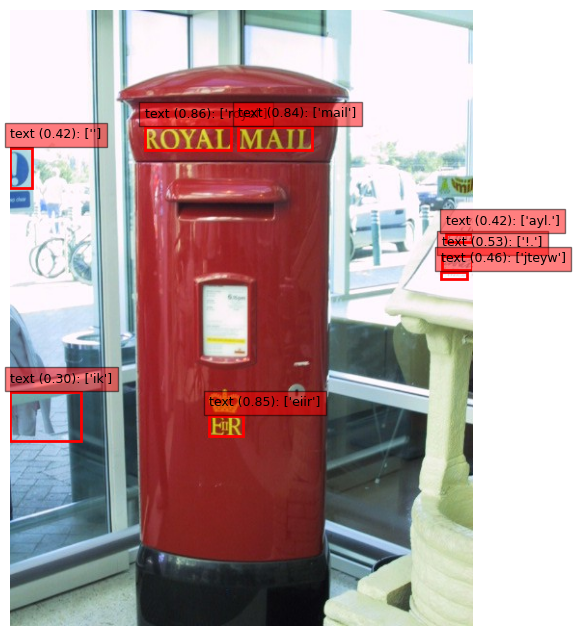

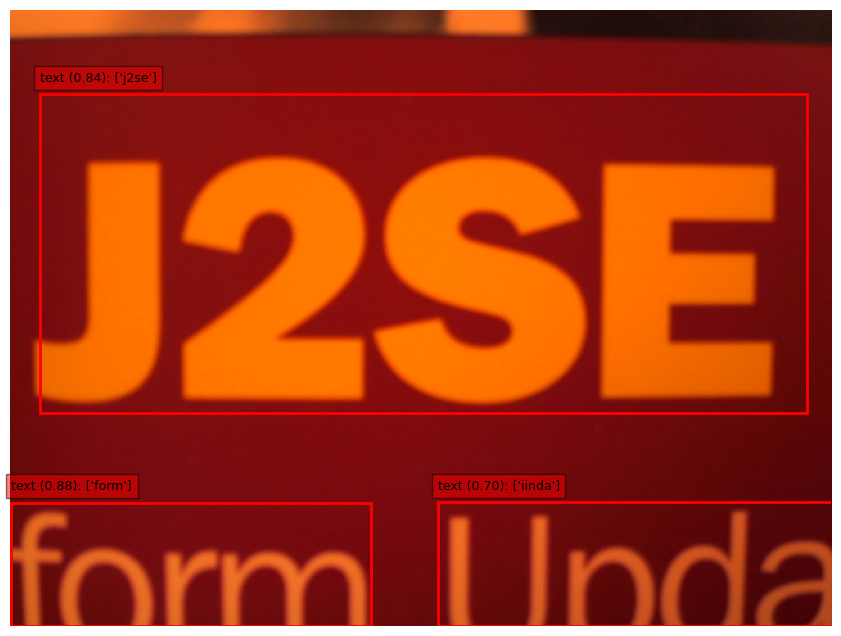

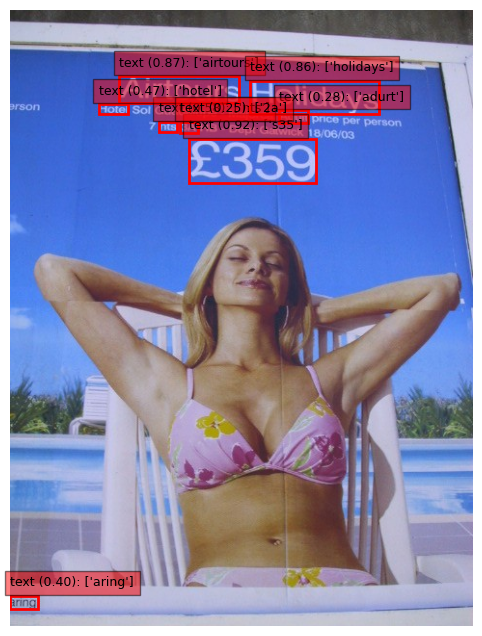

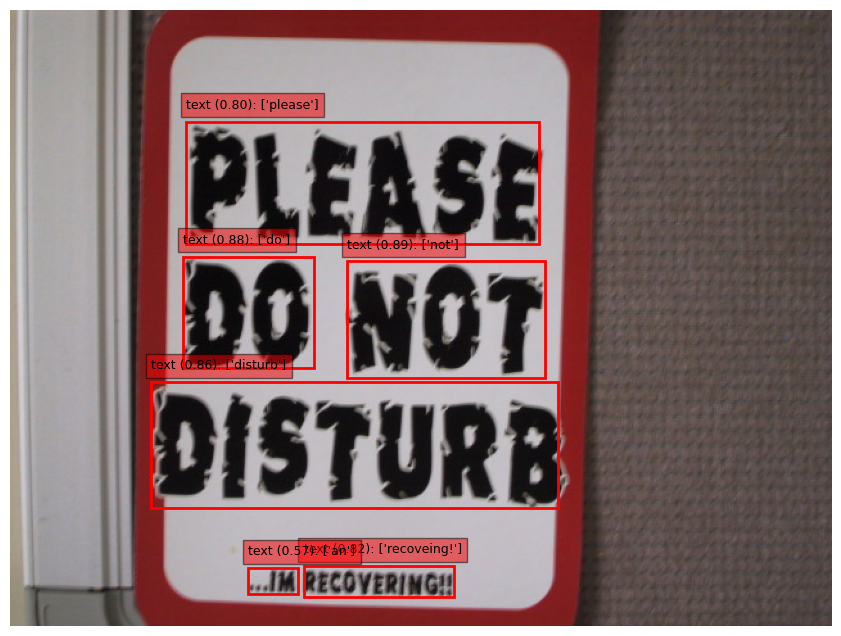

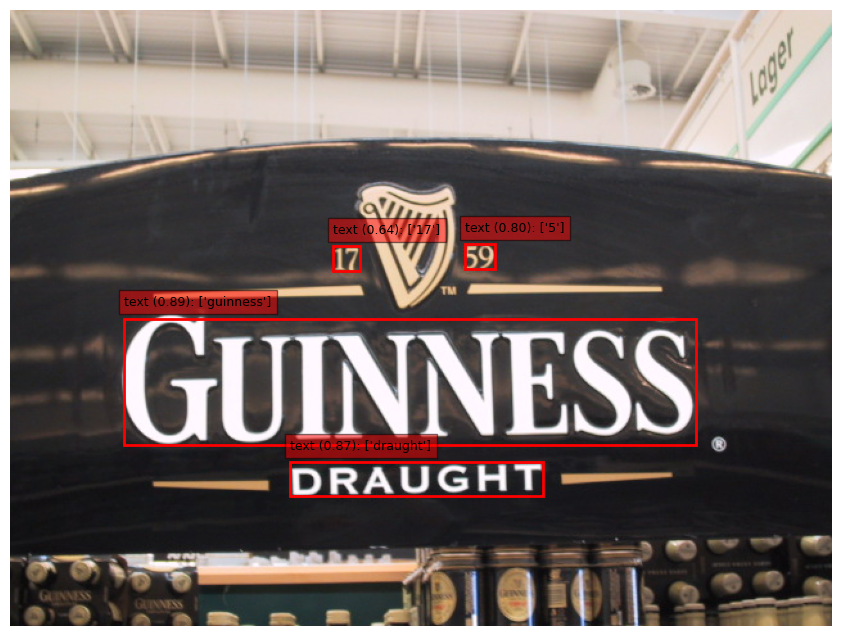

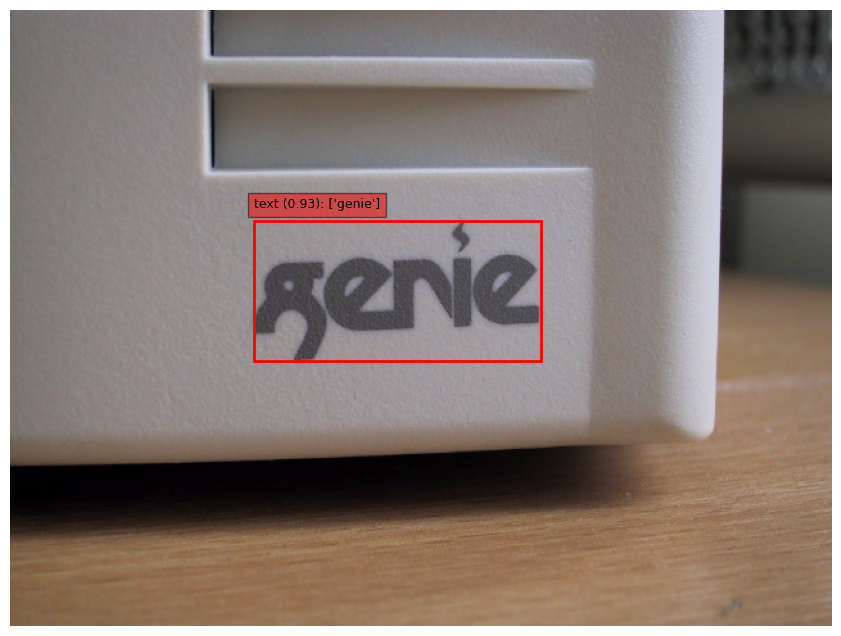

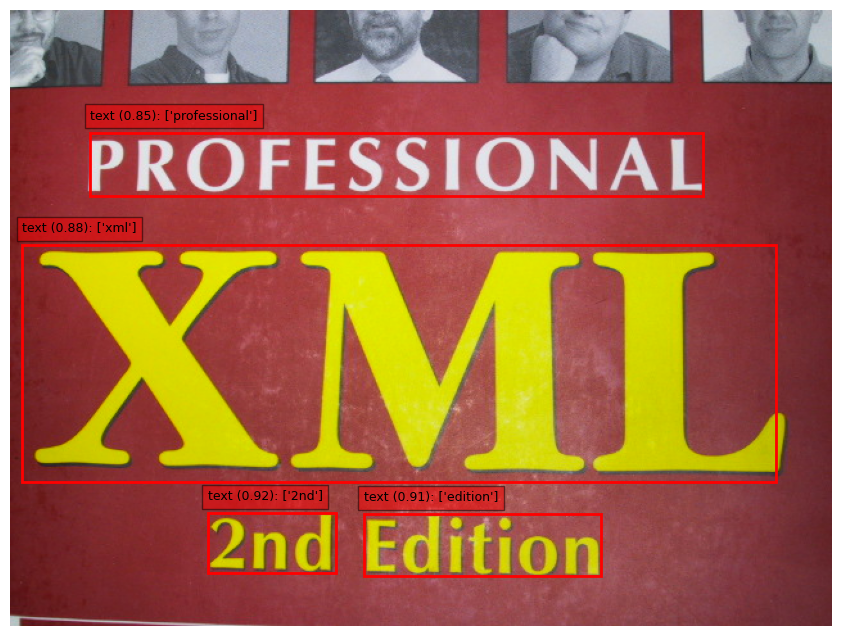

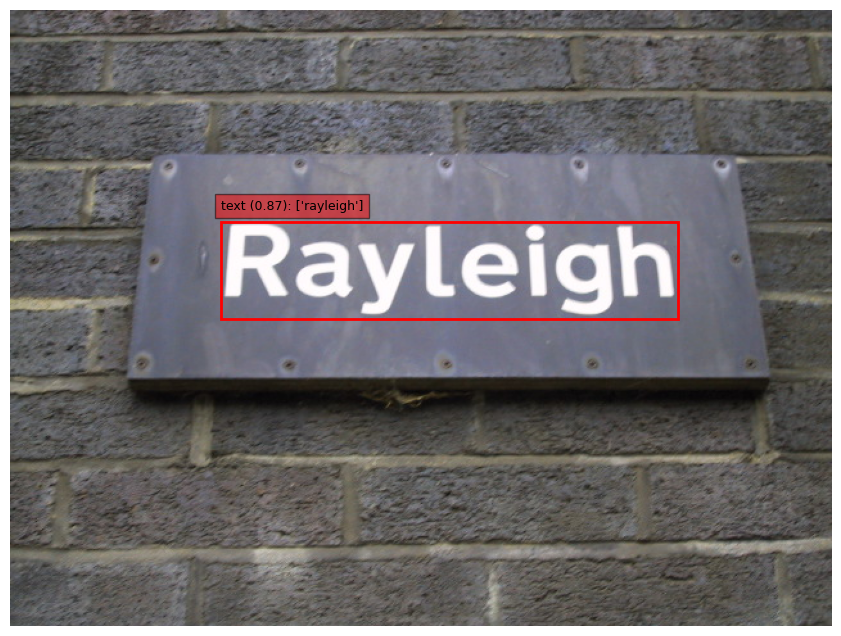

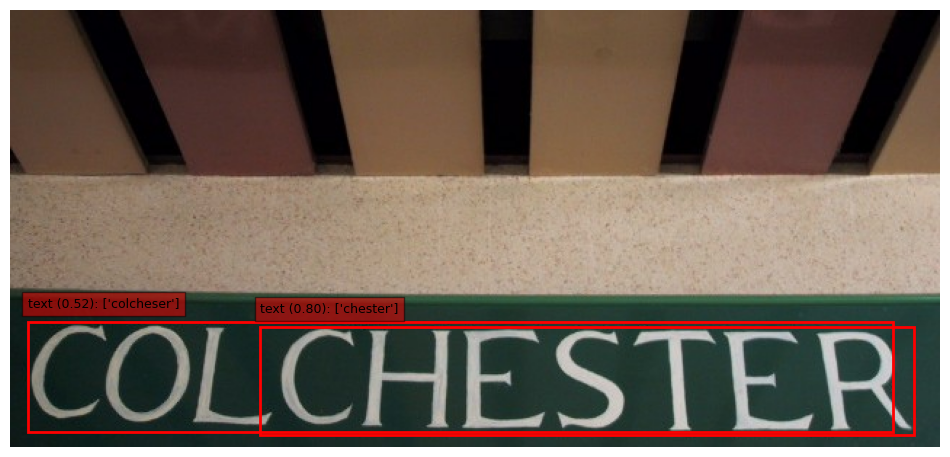

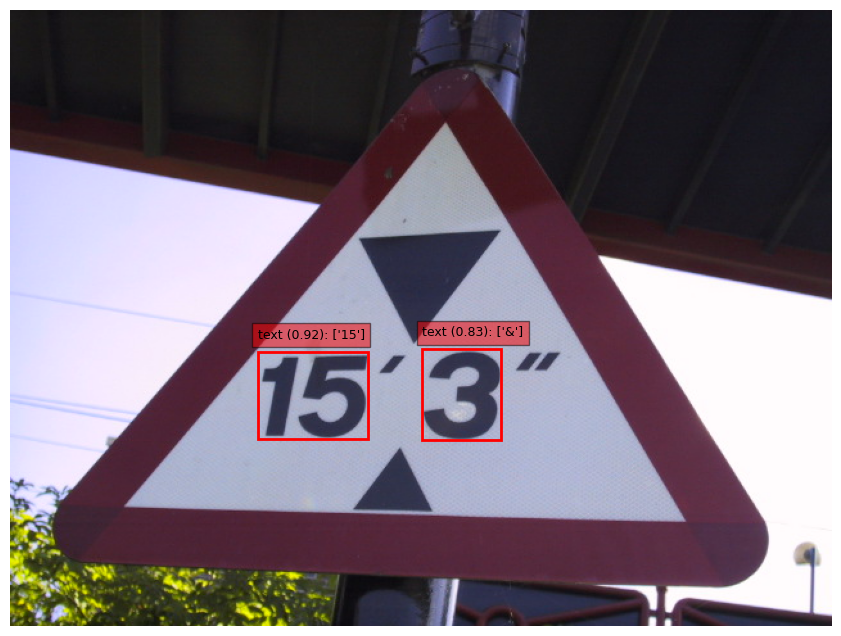

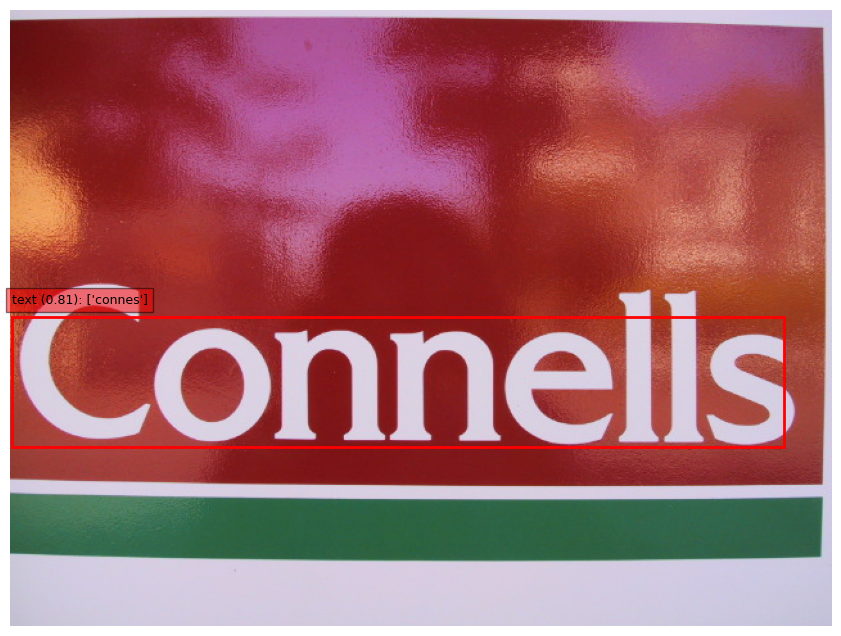

In [13]:
img_dir = "/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002"
inf_transforms = data_transforms["val"]

for idx, img_filename in enumerate(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        text_det_model=yolo,
        text_reg_model=crnn_model,
        idx_to_char=idx2labels,
        device=device,
    )

    if idx == 10:
        break